In [1]:
#Importing required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
pd.options.display.float_format='{:,.2f}'.format
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#Importing Data
df=pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.30,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60,2,0,2,1


In [3]:
#Checking for null values
df.isnull().mean().sort_values(ascending=False)

target     0.00
thal       0.00
ca         0.00
slope      0.00
oldpeak    0.00
exang      0.00
thalach    0.00
restecg    0.00
fbs        0.00
chol       0.00
trestbps   0.00
cp         0.00
sex        0.00
age        0.00
dtype: float64

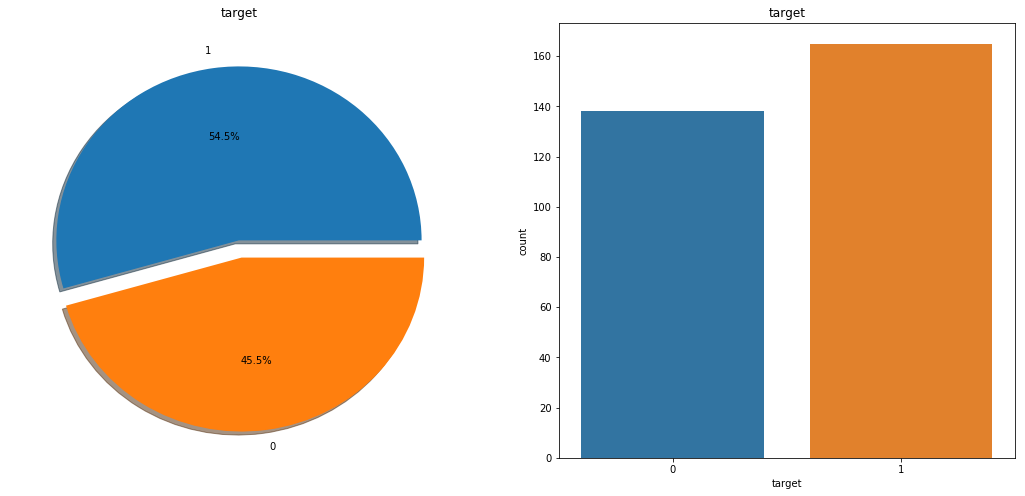

In [4]:
#Checking class distribution
f,ax=plt.subplots(1,2,figsize=(18,8))
df['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot('target',data=df,ax=ax[1])
ax[1].set_title('target')
plt.show()

From above we can see that both class are almost uniformaly distributed. So we don't have class imbalance issue

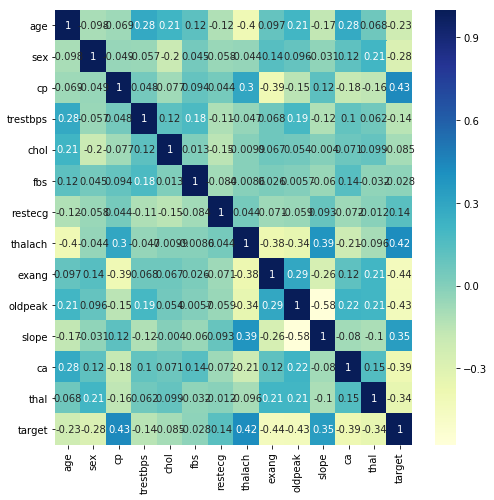

In [5]:
corr=df.corr()
# figure size
plt.figure(figsize=(8, 8))

# heatmap with a color map of choice
sns.heatmap(corr, cmap="YlGnBu",annot=True)
plt.show()

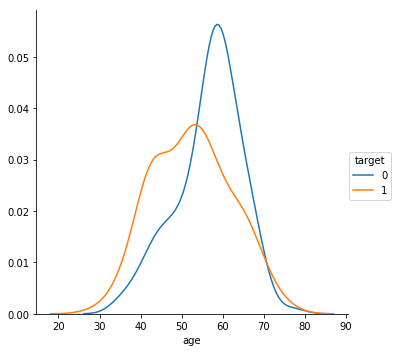

In [6]:
#Heart diseases are more common between 40 to 60 age group
sns.FacetGrid(df, hue="target", size=5).map(sns.kdeplot, "age").add_legend()
plt.show();

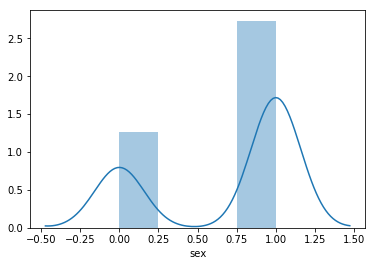

In [7]:
#Gents tend to have more heart diseases 
sns.distplot(df['sex'])

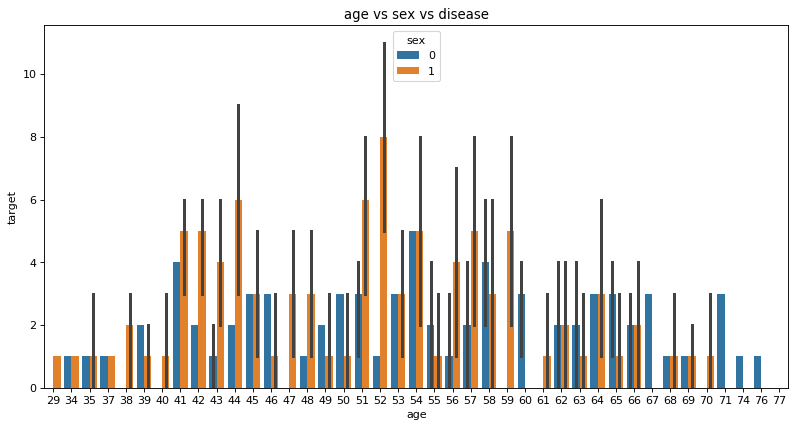

In [8]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
sns.barplot(x='age',y='target',hue='sex',data=df,estimator=np.sum)
plt.title('age vs sex vs disease')
plt.show()
#Males of 52 years old tend to have issues with their heart

In [9]:
col=df.columns
col

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

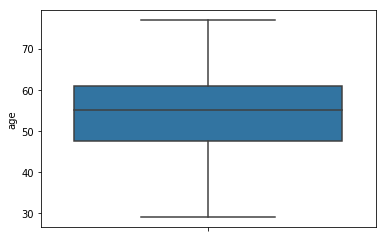

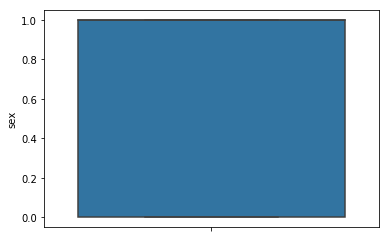

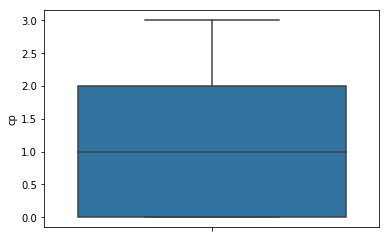

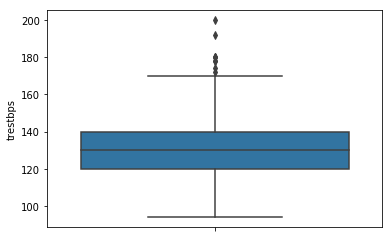

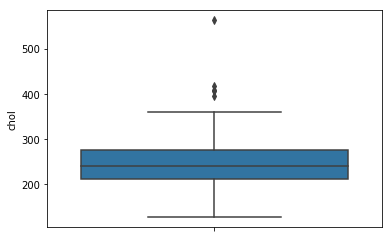

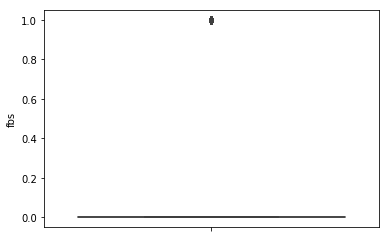

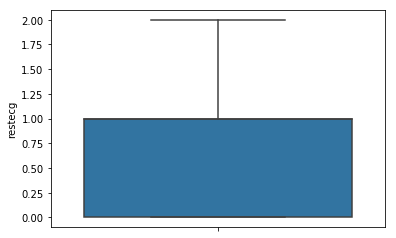

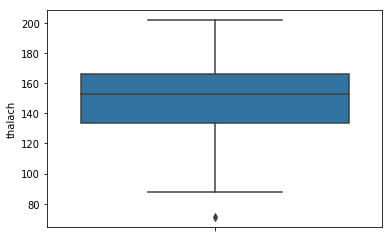

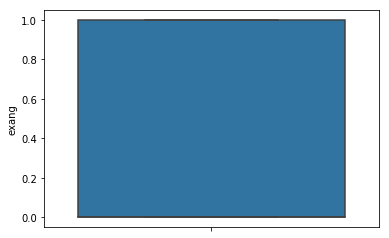

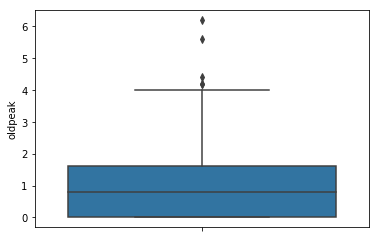

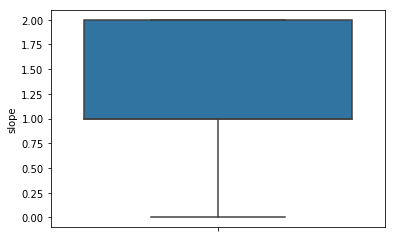

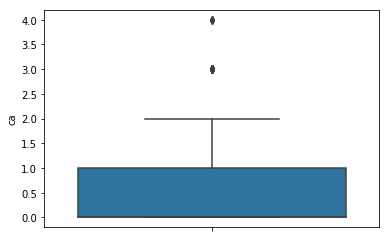

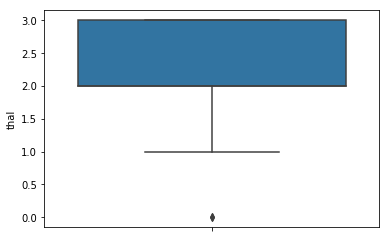

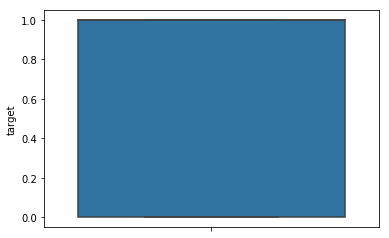

In [10]:
for c in col:
    sns.boxplot( y = c, data = df)
    plt.xticks(rotation=90)
    plt.show()

from above we can see few columns have outliers.Lets try removing them

In [11]:
#Lets see if we can remove any outliers from the data. We will use IQR technique to find any outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

age        13.50
sex         1.00
cp          2.00
trestbps   20.00
chol       63.50
fbs         0.00
restecg     1.00
thalach    32.50
exang       1.00
oldpeak     1.60
slope       1.00
ca          1.00
thal        1.00
target      1.00
dtype: float64


In [12]:
#df shape before removing outliers
df.shape

(303, 14)

In [13]:
#Removing Outliers
df = df[~((df < (Q1 - 3 * IQR)) |(df > (Q3 + 3 * IQR))).any(axis=1)]
#df shape after removing outliers
df.shape
#We have removed around 43 outliers

(257, 14)

In [14]:
#Conversion to categorical variables
df['sex']=df['sex'].astype('category')
df['cp']=df['cp'].astype('category')
df['fbs']=df['fbs'].astype('category')
df['restecg']=df['restecg'].astype('category')
df['exang']=df['exang'].astype('category')
df['slope']=df['slope'].astype('category')
df['ca']=df['ca'].astype('category')
df['thal']=df['thal'].astype('category')
df['target']=df['target'].astype('category')
df.dtypes

age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca          category
thal        category
target      category
dtype: object

In [15]:
y=df['target']

In [16]:
df=pd.get_dummies(df,drop_first=True)
df.head()

,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,restecg_1,...,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3,target_1
1,37,130,250,187,3.50,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1
2,41,130,204,172,1.40,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
3,56,120,236,178,0.80,1,1,0,0,1,...,0,1,0,0,0,0,0,1,0,1
4,57,120,354,163,0.60,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,1
5,57,140,192,148,0.40,1,0,0,0,1,...,1,0,0,0,0,0,1,0,0,1


In [17]:
X=df.drop('target_1',axis=1)

In [28]:
# Splitting the data into train and test and using standard scalar to scale the data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)
col=X_train.columns
scaler = StandardScaler()
#X_train_n=scaler.fit_transform(X_train)
#X_test_n=scaler.fit_transform(X_test)
#X_train_scale=scaler.fit_transform(X_train)
#X_train_n=pd.DataFrame(X_train_n,columns=col)
#X_test_n=pd.DataFrame(X_test_n,columns=col)
y_train=pd.DataFrame({'target':y_train})
y_test=pd.DataFrame({'target':y_test})

In [63]:
#Lets create some functions which will help us in reusing the repeated codes
#Function to build any models by choosing optimal hyperparameters
def model_build(model,param,train_x,test_x,train_y,test_y):
    grid_search = GridSearchCV(estimator =model, param_grid = param,scoring='accuracy', 
                          cv = 2, n_jobs = -1,verbose = 1)
    grid_search.fit(train_x,train_y)
    learner_pca = grid_search.best_estimator_
    model_pca = learner_pca.fit(train_x,train_y)
    print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_,'for',model)
    y_train_pred = model_pca.predict_proba(train_x)[:,1]
    print('AUC on Train data',metrics.roc_auc_score(train_y, y_train_pred))
    y_train_pred_final = pd.DataFrame({'target':train_y.target, 'target_Prob':y_train_pred})
    y_train_pred_final['CustID'] = train_y.index
    
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        y_train_pred_final[i]= y_train_pred_final.target_Prob.map(lambda x: 1 if x > i else 0)
    y_train_pred_final.head()
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(y_train_pred_final.target, y_train_pred_final[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    print(cutoff_df)
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()
    #Making prediction on the test data
    y_test_pred = model_pca.predict_proba(test_x)[:,1]
    print('AUC on Test data',metrics.roc_auc_score(test_y, y_test_pred))
    y_test_pred_final = pd.DataFrame({'target':test_y.target, 'target_Prob':y_test_pred})
    y_test_pred_final['CustID'] = test_y.index
    return(y_train_pred_final,y_test_pred_final)
    

    
    

In [71]:
#Function to validate the models built
def validation_func(y_train_pred_final,y_test_pred_final):
    confusion_train = metrics.confusion_matrix(y_train_pred_final.target, y_train_pred_final.final_predicted )
    confusion_test = metrics.confusion_matrix(y_test_pred_final.target, y_test_pred_final.final_predicted )
    print('Confusion metrics for train data',confusion_train)
    print('Confusion metrics for test data',confusion_test)
    
    #Train validations
    TP_tr = confusion_train[1,1] # true positive 
    TN_tr = confusion_train[0,0] # true negatives
    FP_tr = confusion_train[0,1] # false positives
    FN_tr = confusion_train[1,0] # false negatives
    
    
    TP = confusion_test[1,1] # true positive 
    TN = confusion_test[0,0] # true negatives
    FP = confusion_test[0,1] # false positives
    FN = confusion_test[1,0] # false negatives
    
    print('Train accuracy',metrics.accuracy_score(y_train_pred_final.target, y_train_pred_final.final_predicted))
    print('Sensitivity of Train',TP_tr / float(TP_tr+FN_tr))
    print('Specificity of train',TN_tr / float(TN_tr+FP_tr))
    print('Calculate false postive rate - predicting disease when customer does not have disease for trian',FP_tr/ float(TN_tr+FP_tr))
    
    print('Test Accuracy',metrics.accuracy_score(y_test_pred_final.target, y_test_pred_final.final_predicted))
    print('Sensitivity of test',TP / float(TP+FN))
    print('Specificity of test',TN / float(TN+FP))
    print('Calculate false postive rate - predicting diesease when customer does not have disease for test',FP/ float(TN+FP))



In [72]:
#Lets start with Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.2s finished


We can get accuracy of 0.7821229050279329 using {'C': 10, 'penalty': 'l1'} for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
AUC on Train data 0.9308632543926662
      prob  accuracy  sensi  speci
0.00  0.00      0.57   1.00   0.00
0.10  0.10      0.77   0.99   0.47
0.20  0.20      0.79   0.96   0.56
0.30  0.30      0.83   0.95   0.66
0.40  0.40      0.85   0.93   0.74
0.50  0.50      0.89   0.93   0.83
0.60  0.60      0.87   0.87   0.87
0.70  0.70      0.83   0.77   0.91
0.80  0.80      0.78   0.67   0.92
0.90  0.90      0.70   0.50   0.97


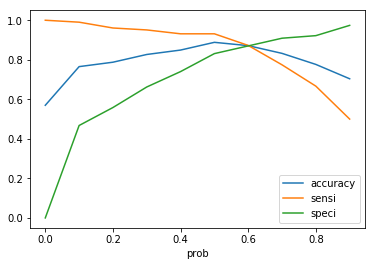

AUC on Test data 0.9428007889546351


In [73]:
y_train_pred_final,y_test_pred_final=model_build(LogisticRegression(),log_reg_params,X_train, X_test, y_train, y_test)

In [74]:
#We are getting decent AUC of 94% on test data. By seeing the above table its safe to choose custoff at .5. It has relatively high sensitivity and also good specificity
y_train_pred_final['final_predicted'] = y_train_pred_final.target_Prob.map( lambda x: 1 if x > 0.5 else 0)

In [75]:
y_test_pred_final['final_predicted'] = y_test_pred_final.target_Prob.map(lambda x: 1 if x > 0.5 else 0)

In [76]:
#Now lets validate our model and see what sensitivity and specifity we get on test data
validation_func(y_train_pred_final,y_test_pred_final)

Confusion metrics for train data [[64 13]
 [ 7 95]]
Confusion metrics for test data [[32  7]
 [ 3 36]]
Train accuracy 0.888268156424581
Sensitivity of Train 0.9313725490196079
Specificity of train 0.8311688311688312
Calculate false postive rate - predicting churn when customer does not have churned for trian 0.16883116883116883
Test Accuracy 0.8717948717948718
Sensitivity of test 0.9230769230769231
Specificity of test 0.8205128205128205
Calculate false postive rate - predicting churn when customer does not have churned for test 0.1794871794871795


In [77]:
#lets try our hands with RandomForest
Ran_param_grid = {
    'max_depth': [12,16,20],
    'min_samples_leaf': range(50, 400, 50),
    'min_samples_split': range(50, 400, 50),
    'n_estimators': [30,50,70], 
    'max_features': [10,20]
}

Fitting 2 folds for each of 882 candidates, totalling 1764 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 1764 out of 1764 | elapsed:  1.1min finished


We can get accuracy of 0.5698324022346368 using {'max_depth': 12, 'max_features': 10, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 30} for RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
AUC on Train data 0.8202826585179527
      prob  accuracy  sensi  speci
0.00  0.00      0.57   1.00   0.00
0.10  0.10      0.57   1.00   0.00
0.20  0.20      0.57   1.00   0.00
0.30  0.30      0.57   1.00   0.00
0.40  0.40      0.75   0.97   0.45
0.50  0.50      0.74   0.87   0.57
0.60  0.60      0.73   0.65   0.84
0.70  0.70      0.61   0.40   0.90
0.80  0.80      0.43   0.00   1.00
0.90  0.90      0.43   0.0

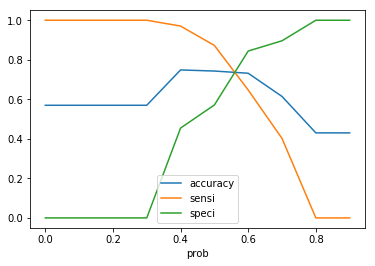

AUC on Test data 0.9171597633136095


In [78]:
y_train_pred_final,y_test_pred_final=model_build(RandomForestClassifier(),Ran_param_grid,X_train, X_test, y_train, y_test)

In [79]:
#We are getting decent AUC  on test data. By seeing the above table its safe to choose custoff at .4. It has relatively high sensitivity 
y_train_pred_final['final_predicted'] = y_train_pred_final.target_Prob.map( lambda x: 1 if x > 0.4 else 0)
y_test_pred_final['final_predicted'] = y_test_pred_final.target_Prob.map(lambda x: 1 if x > 0.4 else 0)

In [80]:
#Now lets validate our model and see what sensitivity and specifity we get on test data
validation_func(y_train_pred_final,y_test_pred_final)

Confusion metrics for train data [[35 42]
 [ 3 99]]
Confusion metrics for test data [[19 20]
 [ 1 38]]
Train accuracy 0.7486033519553073
Sensitivity of Train 0.9705882352941176
Specificity of train 0.45454545454545453
Calculate false postive rate - predicting churn when customer does not have churned for trian 0.5454545454545454
Test Accuracy 0.7307692307692307
Sensitivity of test 0.9743589743589743
Specificity of test 0.48717948717948717
Calculate false postive rate - predicting churn when customer does not have churned for test 0.5128205128205128


From above two models we can conclude that, 
If we are concentrating on Sensitivity, we can go with Random Forest. RF will predict disease 97% accurately. But it will also predict 0 as 0 for only 45 %. That means for 55% of people who do not have disease, it will predict either way.
But Logistic regression on the other habs have good balance between Sensitivity and Specificity.